In [24]:
# !pip install keras_tuner

In [25]:
import h5py
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('ggplot')

plt.rc('figure', autolayout=True)

tf.__version__

'2.8.2'

In [26]:
train_dataset = h5py.File('datasets/train_signs.h5', "r")
test_dataset = h5py.File('datasets/test_signs.h5', "r")

In [27]:
x_train = np.array(train_dataset['train_set_x'])
y_train = np.array(train_dataset['train_set_y'])
x_test = np.array(test_dataset['test_set_x'])
y_test = np.array(test_dataset['test_set_y'])

In [28]:
print(type(x_train))
print(x_train.shape)


<class 'numpy.ndarray'>
(1080, 64, 64, 3)


In [29]:
unique_labels = np.unique(y_train)
print(unique_labels,len(unique_labels))

[0 1 2 3 4 5] 6


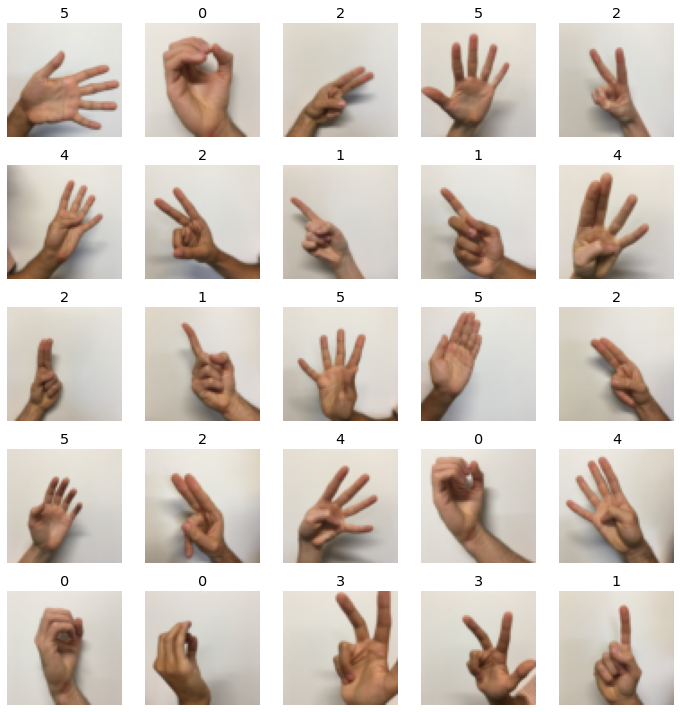

In [30]:

plt.figure(figsize=(10, 10))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(x_train[i])
    plt.title(y_train[i])
    plt.axis("off")

In [31]:
x_train = x_train/255.0
x_test = x_test/255.0

In [32]:

model = tf.keras.models.Sequential([tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(128, activation = tf.nn.relu),
                                    tf.keras.layers.Dense(128, activation = tf.nn.relu),
                                    tf.keras.layers.Dense(6, activation = tf.nn.softmax)])


In [33]:
model.compile(optimizer = tf.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics =['accuracy'])


Epoch 1/100
34/34 [==============================] - 1s 21ms/step - loss: 2.9721 - accuracy: 0.1796 - val_loss: 1.8305 - val_accuracy: 0.1917
Epoch 2/100
34/34 [==============================] - 1s 15ms/step - loss: 1.8380 - accuracy: 0.2241 - val_loss: 1.7020 - val_accuracy: 0.2417
Epoch 3/100
34/34 [==============================] - 1s 16ms/step - loss: 1.7217 - accuracy: 0.2787 - val_loss: 1.6150 - val_accuracy: 0.3750
Epoch 4/100
34/34 [==============================] - 1s 15ms/step - loss: 1.7314 - accuracy: 0.3074 - val_loss: 1.9485 - val_accuracy: 0.2167
Epoch 5/100
34/34 [==============================] - 1s 15ms/step - loss: 1.6219 - accuracy: 0.3231 - val_loss: 1.5189 - val_accuracy: 0.3167
Epoch 6/100
34/34 [==============================] - 1s 15ms/step - loss: 1.4909 - accuracy: 0.4157 - val_loss: 1.3468 - val_accuracy: 0.5333
Epoch 7/100
34/34 [==============================] - 1s 15ms/step - loss: 1.2974 - accuracy: 0.5167 - val_loss: 1.2412 - val_accuracy: 0.5333
Epoch 

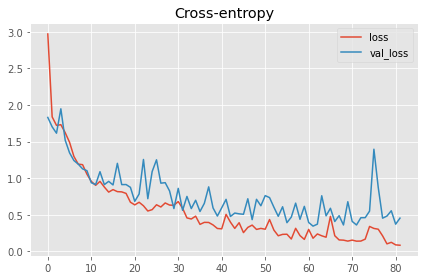

In [34]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=20,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=32,
    epochs=100,
    callbacks=[early_stopping]
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")

In [35]:
model.evaluate(x_test, y_test)


4/4 [==============================] - 0s 5ms/step - loss: 0.3439 - accuracy: 0.8833


[0.3439383804798126, 0.8833333253860474]

Tuning

In [36]:
def evaluate_model(model, X_test, y_test):
    """
    evaluate model on test set and show results in dataframe.
    
    Parameters
    ----------
    model : keras model
        trained keras model.
    X_test : numpy array
        Features of holdout set.
    y_test : numpy array
        Labels of holdout set.
        
    Returns
    -------
    display_df : DataFrame
        Pandas dataframe containing evaluation results.
    """
    eval_dict = model.evaluate(X_test, y_test, return_dict=True)
    
    display_df = pd.DataFrame([eval_dict.values()], columns=[list(eval_dict.keys())])
    
    return display_df

In [37]:

# Evaluate model on test set and add results to dataframe
results = evaluate_model(model, x_test, y_test)

# Set index to 'Baseline'
results.index = ['Baseline']

# Display results
results.head()

4/4 [==============================] - 0s 6ms/step - loss: 0.3439 - accuracy: 0.8833


,loss,accuracy
Baseline,0.343938,0.883333


In [38]:
# def build_model(hp):
#     """
#     Builds model and sets up hyperparameter space to search.
    
#     Parameters
#     ----------
#     hp : HyperParameter object
#         Configures hyperparameters to tune.
        
#     Returns
#     -------
#     model : keras model
#         Compiled model with hyperparameters to tune.
#     """
#     # Initialize sequential API and start building model.
#     model = keras.Sequential()
#     model.add(keras.layers.Flatten())
    
#     # Tune the number of hidden layers and units in each.
#     # Number of hidden layers: 1 - 4
#     # Number of Units: 64 - 512 with stepsize of 64
#     for i in range(1, hp.Int("num_layers", 2, 5)):
#         model.add(
#             keras.layers.Dense(
#                 units=hp.Int("units_" + str(i), min_value=64, max_value=512, step=64),
#                 activation="relu")
#             )
        
#         # Tune dropout layer with values from 0 - 0.3 with stepsize of 0.1.
#         model.add(keras.layers.Dropout(hp.Float("dropout_" + str(i), 0, 0.3, step=0.1)))
    
#     # Add output layer.
#     model.add(keras.layers.Dense(units=6, activation="softmax"))
    
#     # Tune learning rate for Adam optimizer with values from 0.001, or 0.0001
#     hp_learning_rate = hp.Choice("learning_rate", values=[1e-3, 1e-4])
    
#     # Define optimizer, loss, and metrics
#     model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
#                   loss=keras.losses.SparseCategoricalCrossentropy(),
#                   metrics=["accuracy"])
    
#     return model

In [39]:
# # Instantiate the tuner
# import keras_tuner as kt
# tuner = kt.Hyperband(build_model,
#                      objective="val_accuracy",
#                      max_epochs=20,
#                      factor=3,
#                      hyperband_iterations=10,
#                      directory="kt_dir",
#                      project_name="kt_hyperband",)
# # Display search space summary
# tuner.search_space_summary()

In [40]:
# stop_early = early_stopping

# tuner.search(x_train, y_train, epochs=100, validation_split=0.2, callbacks=[stop_early], verbose=2)

In [41]:
# # Get the optimal hyperparameters from the results
# best_hps=tuner.get_best_hyperparameters()[0]

# # Build model
# h_model = tuner.hypermodel.build(best_hps)

# # Train the hypertuned model
# history = h_model.fit(x_train, y_train, epochs=100, validation_split=0.2, callbacks=[stop_early], verbose=2)

# history_df = pd.DataFrame(history.history)
# history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")

In [42]:
# h_model.summary()

In [43]:
# tuner.results_summary()

```
Results summary
Results in kt_dir/kt_hyperband
Showing 10 best trials
<keras_tuner.engine.objective.Objective object at 0x7f98bdd16610>
Trial summary
Hyperparameters:
num_layers: 2
units_1: 256
dropout_1: 0.0
learning_rate: 0.001
units_2: 192
dropout_2: 0.30000000000000004
units_3: 384
dropout_3: 0.0
units_4: 64
dropout_4: 0.2
tuner/epochs: 20
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.6759259104728699

```



Epoch 1/100
34/34 [==============================] - 2s 30ms/step - loss: 4.5143 - accuracy: 0.1954 - val_loss: 2.2533 - val_accuracy: 0.2167
Epoch 2/100
34/34 [==============================] - 1s 25ms/step - loss: 1.9297 - accuracy: 0.2667 - val_loss: 1.8548 - val_accuracy: 0.2583
Epoch 3/100
34/34 [==============================] - 1s 24ms/step - loss: 1.8178 - accuracy: 0.3380 - val_loss: 1.6527 - val_accuracy: 0.3250
Epoch 4/100
34/34 [==============================] - 1s 25ms/step - loss: 1.5933 - accuracy: 0.4093 - val_loss: 1.5177 - val_accuracy: 0.4417
Epoch 5/100
34/34 [==============================] - 1s 25ms/step - loss: 1.4204 - accuracy: 0.4852 - val_loss: 1.3487 - val_accuracy: 0.5167
Epoch 6/100
34/34 [==============================] - 1s 25ms/step - loss: 1.4117 - accuracy: 0.5009 - val_loss: 1.2582 - val_accuracy: 0.5417
Epoch 7/100
34/34 [==============================] - 1s 24ms/step - loss: 1.2901 - accuracy: 0.5306 - val_loss: 1.4170 - val_accuracy: 0.3917
Epoch 

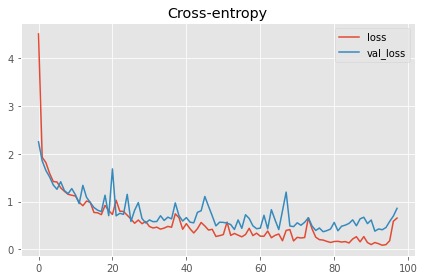

In [51]:

h_model = tf.keras.models.Sequential([tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(256, activation = tf.nn.relu),
                                    tf.keras.layers.Dense(192,kernel_regularizer=tf.keras.regularizers.L2(1e-3),bias_regularizer=tf.keras.regularizers.L2(1e-3), activation = tf.nn.relu),
                                    tf.keras.layers.Dense(6, activation = tf.nn.softmax)])
h_model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.001),
              loss = 'sparse_categorical_crossentropy',
              metrics =['accuracy'])



h_history = h_model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=32,
    epochs=100,
    callbacks=[early_stopping]
)
h_history_df = pd.DataFrame(h_history.history)
h_history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
print(h_model.evaluate(x_test,y_test))

In [52]:
h_model.evaluate(x_test,y_test)

4/4 [==============================] - 0s 8ms/step - loss: 0.3686 - accuracy: 0.8917


[0.36861172318458557, 0.8916666507720947]

In [53]:
# Evaluate model on test set
hyper_df = evaluate_model(h_model, x_test, y_test)

# Set index to hypertuned
hyper_df.index = ["Hypertuned"]

# Append results in dataframe
results.append(hyper_df)

4/4 [==============================] - 0s 8ms/step - loss: 0.3686 - accuracy: 0.8917


,loss,accuracy
Baseline,0.343938,0.883333
Hypertuned,0.368612,0.891667
